# Finetuning with Trainer and text-classification model validation

In [1]:
# Original notebook created by http://bkonat[dot]home[dot]amu[dot]edu[dot]pl

In [2]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
   colab = True
else:
   colab = False
   
if colab:
    !pip install transformers[torch]
    !pip install accelerate -U
    !pip install datasets
    !pip install torchinfo
    #ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U

In [3]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import seaborn as sn
import torch
from sklearn.model_selection import train_test_split

from datasets import load_dataset, Dataset, DatasetDict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from torchinfo import summary
from transformers import AutoModelForSequenceClassification, AutoConfig, Trainer, TrainingArguments, DataCollatorWithPadding, AutoTokenizer, pipeline
from transformers.modelcard import parse_log_history

# Prepare parameters for each run of finetnuning

In [4]:
# from huggingface_hub import notebook_login
# notebook_login()

In [9]:
import itertools

params_tested = {'model': ['distilbert-base-cased', 'b'],
                 'num_train_epochs': [10],
                 'save_strategy': ['no']}
keys = list(params_tested.keys())

combinations = list(itertools.product(*params_tested.values()))
result = [{keys[i]: combination[i] for i in range(len(keys))} for combination in combinations]

print(result)

[{'model': 'distilbert-base-cased', 'num_train_epochs': 10, 'save_strategy': 'no'}, {'model': 'b', 'num_train_epochs': 10, 'save_strategy': 'no'}]


In [5]:
models = ['albert', 'bart', 'bert', 'big_bird', 'bigbird_pegasus', 'biogpt', 'bloom', 'camembert', 'canine', 'code_llama', 'convbert', 'ctrl', 'data2vec-text', 'deberta', 'deberta-v2', 'distilbert', 'electra', 'ernie', 'ernie_m', 'esm', 'falcon', 'flaubert', 'fnet', 'funnel', ')gemma', 'gpt-sw3', 'gpt2', 'gpt_bigcode', 'gpt_neo', 'gpt_neox', 'gptj', 'ibert', 'layoutlm', 'layoutlmv2', 'layoutlmv3', 'led', 'lilt', 'llama', 'longformer', 'luke', 'markuplm', 'mbart', 'mega', 'megatron-bert', 'mistral', 'mixtral', 'mobilebert', 'mpnet', 'mpt', 'mra', 'mt5', 'mvp', 'nezha', 'nystromformer', 'open-llama', 'openai-gpt', 'opt', 'perceiver', 'persimmon', 'phi', 'plbart', 'qdqbert', 'qwen2', 'reformer', 'rembert', 'roberta', 'roberta-prelayernorm', 'roc_bert', 'roformer', 'squeezebert', 'stablelm', 'starcoder2', 't5', 'tapas', 'transfo-xl', 'umt5', 'xlm', 'xlm-roberta', 'xlm-roberta-xl', 'xlnet', 'xmod', 'yoso',]

# tested = 'distilbert-base-cased', 'camembert-base', 'ctrl', 'transfo-xl-wt103', 'xlnet-base-cased', 'roberta-base', 'distilroberta-base', 'flaubert/flaubert_base_cased'
#too weak pc (cannot be loaded or runs at speeds <1 it/s) = 'albert-xlarge-v1', 't5-11B', 'LongformerForSequenceClassification', 'xlm-roberta-base', 'allenai/longformer-base-4096', 'facebook/bart-large',  flaubert/flaubert_large_cased (stopped at 0.5 epoch), 

#need changes to run (check error logs) =  

models = ['distilbert-base-cased']

# model_path = 'SamLowe/roberta-base-go_emotions'
# model_path = 'distilbert-base-uncased'
# model_path = 'xlmoberta'


# run_looped = True
# 
# train_params = {
#     'model': 'cardiffnlp/twitter-roberta-base-sentiment-latest',
#     'num_train_epochs': 1,
#     'save_strategy': 'no'
# }


train_params_looped = [{
    'model': i,
    'num_train_epochs': 1,
    'save_strategy': 'no'
} for i in models]

train_params_looped

[{'model': 'flaubert/flaubert_base_cased',
  'num_train_epochs': 10,
  'save_strategy': 'no'},
 {'model': 'flaubert/flaubert_large_cased',
  'num_train_epochs': 10,
  'save_strategy': 'no'},
 {'model': 'gpt2-xl', 'num_train_epochs': 10, 'save_strategy': 'no'}]

# Load data via datasets package and prepare _label to int_ dict

In [6]:
# PolarIs-Pathos
if colab:
  from google.colab import drive
  drive.mount('/content/drive')
  data_path = 'drive/MyDrive/master_lm/PolarIs-Pathos.xlsx'
else:
  data_path = 'data/PolarIs-Pathos.xlsx'

df = pd.read_excel(data_path)
df['label'] = df[['No_pathos', 'Positive', 'Negative']].idxmax(axis=1)
df = df.rename(columns={'Sentence':'sentence'})

target_map = {k:i for i,k in enumerate(df['label'].unique())}
reversed_target_map = {v:k for k, v in target_map.items()}

X, y = df['sentence'], df['label'].map(target_map)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42, stratify=y_test)

ds = DatasetDict()
ds['train'] = Dataset.from_pandas(pd.concat([X_train, y_train], axis=1))
ds['test'] = Dataset.from_pandas(pd.concat([X_test, y_test], axis=1))
ds['validate'] = Dataset.from_pandas(pd.concat([X_val, y_val], axis=1))
ds

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', '__index_level_0__'],
        num_rows: 12470
    })
    test: Dataset({
        features: ['sentence', 'label', '__index_level_0__'],
        num_rows: 1559
    })
    validate: Dataset({
        features: ['sentence', 'label', '__index_level_0__'],
        num_rows: 1559
    })
})

## Finetuning

In [7]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

def save_logs_from_training_run(trainer, model_name, timestamp, trained_model_path, colab):
    log_history = parse_log_history(trainer.state.log_history)
    log_df = pd.DataFrame(log_history[1])
    log_df.insert(0, 'model', model_name)
    log_df.insert(0, 'timestamp', timestamp)
    log_df['model_path'] = trained_model_path
    log_df['samples_per_s'] = log_history[0]['train_samples_per_second']
    log_df['steps_per_s'] = log_history[0]['train_steps_per_second']
    log_df['colab'] = colab
    
    log_df.to_csv('output/training_logs.csv', mode='a', header= not os.path.isfile('output/training_logs.csv'), index=False)

### Training

In [ ]:
def finetune(train_params, ds):
    print(train_params['model'])
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    trained_model_path = f'output/models/{train_params['model']}_{timestamp}'
    
    try:
        def tokenize_fn(batch):
            return tokenizer(batch['sentence'], truncation=True)
        
        #Tokenize dataset
        tokenizer = AutoTokenizer.from_pretrained(train_params['model'])
        tokenized_datasets = ds.map(tokenize_fn, batched=True)
        
        #Change labels
        config = AutoConfig.from_pretrained(train_params['model'])
        config.id2label = reversed_target_map
        config.label2id = target_map
        
        #Load model
        model = AutoModelForSequenceClassification.from_pretrained(
            train_params['model'], config=config, ignore_mismatched_sizes=True)
        
        if torch.cuda.is_available():
            model = model.cuda()
            device = 'gpu'
        else:
            device = 'cpu'
        
    
        
        training_args = TrainingArguments(
          output_dir=f'{trained_model_path}/checkpoints',
          evaluation_strategy='epoch',
          logging_strategy='epoch',
          save_strategy= train_params['save_strategy'],
          num_train_epochs=train_params['num_train_epochs'],
          per_device_train_batch_size=16,
          per_device_eval_batch_size=64,
        )
        
        trainer = Trainer(
            model,
            training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["test"],
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )

        trainer.train()    
        save_logs_from_training_run(trainer, train_params['model'], timestamp, trained_model_path, colab)
        
    except Exception as e:
        print(e)
        err_df = pd.DataFrame([[trained_model_path, str(e)]])
        err_df.to_csv('output/error_logs.csv', mode='a', index=False)
        
        
    
for train_params in train_params_looped:
    finetune(train_params, ds)

flaubert/flaubert_base_cased


Map:   0%|          | 0/12470 [00:00<?, ? examples/s]

Map:   0%|          | 0/1559 [00:00<?, ? examples/s]

Map:   0%|          | 0/1559 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/553M [00:00<?, ?B/s]

C:\Users\Jakub\DataspellProjects\EQILLM\venv\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Jakub\.cache\huggingface\hub\models--flaubert--flaubert_base_cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of FlaubertForSequenceClassification were not initialized from the model check

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.804300,0.770413,0.682489,0.270428
2,0.788400,0.811212,0.682489,0.270428
3,0.782700,0.782075,0.682489,0.270428
4,0.781500,0.773676,0.682489,0.270428
5,0.778800,0.770337,0.682489,0.270428
6,0.777100,0.778929,0.682489,0.270428
7,0.777100,0.770037,0.682489,0.270428
8,0.775800,0.775840,0.682489,0.270428
9,0.773900,0.770870,0.682489,0.270428
10,0.773800,0.774188,0.682489,0.270428


flaubert/flaubert_large_cased


Map:   0%|          | 0/12470 [00:00<?, ? examples/s]

Map:   0%|          | 0/1559 [00:00<?, ? examples/s]

Map:   0%|          | 0/1559 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/1.49G [00:00<?, ?B/s]

C:\Users\Jakub\DataspellProjects\EQILLM\venv\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Jakub\.cache\huggingface\hub\models--flaubert--flaubert_large_cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of FlaubertForSequenceClassification were not initialized from the model chec

Epoch,Training Loss,Validation Loss


### Classification

In [ ]:
# Get last epoch number
checkpoint_no = [int(i.rsplit('-')[-1]) for i in os.listdir(f'{trained_model_path}/checkpoints/') if i.startswith('checkpoint')]
checkpoint_no.sort(reverse=True)
print(checkpoint_no)
chosen_checkpoint = checkpoint_no[0]
checkpoint_path = f'{trained_model_path}/checkpoints/checkpoint-{chosen_checkpoint}'

In [19]:
def validate(checkpoint_path, validation_ds, reversed_target_map, save=True):
    task = 'text-classification'
    classif_out_path = checkpoint_path.rsplit('/', 1)[0]
    classifier = pipeline(task, model=checkpoint_path, device=0)
    predicted = classifier(validation_ds['sentence'])
    out_df = pd.DataFrame(ds['sentence', 'label'], columns=['sentence', 'label'])
    out_df['predicted'] = [i['label'] for i in predicted]
    return predicted

In [21]:
validated_df = pd.concat([X_val, y_val], axis=1).copy(deep=True)
# validated_df = ds_dict['validate'].copy(deep=True)
validated_df['predicted'] = [i['label'] for i in pred_val]
validated_df['label'] = validated_df['label'].map(reversed_target_map)
validated_df.to_csv(f'{trained_model_path}/validated.csv', index=False)

acc: 0.742142398973701
f1: 0.5915645247082992


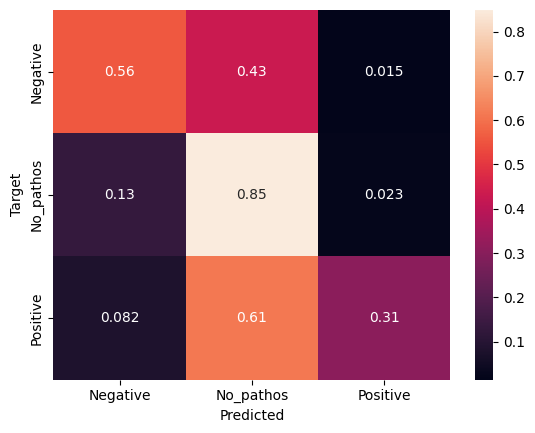

In [22]:
print("acc:", accuracy_score(validated_df['label'], validated_df['predicted']))
print("f1:", f1_score(validated_df['label'], validated_df['predicted'], average='macro'))

def plot_cm(cm):
    classes = list(target_map.keys())
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='.2g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

cm = confusion_matrix(validated_df['label'], validated_df['predicted'], normalize='true')
plot_cm(cm)

In [23]:
validated_df.groupby('label').count()

,sentence,predicted
label,,
Negative,410,410
No_pathos,1064,1064
Positive,85,85
